# Stratified QG Vortex Stability in Firdrake

In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

### Linear Stability Problem

$$
c\left[ \frac{1}{r}\partial_r\left(r\partial_r\right) - \frac{m^2}{r^2} + \frac{1}{Bu^2}\partial_{zz} \right]\widehat{\psi} = 
\left[ \frac{1}{r}\partial_r\Psi \left( \frac{1}{r}\partial_r\left(r\partial_r\right) - \frac{m^2}{r^2} + \frac{1}{Bu^2}\partial_{zz} \right) - \frac{1}{r}\partial_rQ \right]\widehat{\psi}
$$

### Weak form

Multiply the linear stability problem by $r^2$ to remove the singularities, multiply by the test function $\phi$, and integrate over $r$.

***Note that $\partial_r\Psi = U_\theta$.***

***Note the extra factor of $r$ from $dA$***

***Note: boundary condition terms are currently utterly ignored***

***Note: need to add beta***

\begin{align*}
c \int r^3\phi \left[ \frac{1}{r}\partial_r\left(r\partial_r\right) - \frac{m^2}{r^2} + \frac{1}{Bu^2}\partial_{zz} \right]\widehat{\psi} \, dr 
&= \int r^3\phi \left[ \frac{1}{r}\partial_r\Psi \left( \frac{1}{r}\partial_r\left(r\partial_r\right) - \frac{m^2}{r^2} + \frac{1}{Bu^2}\partial_{zz}\right) - \frac{1}{r}\partial_rQ \right]\widehat{\psi} \, dr \\
~
c \int \phi \left[ r^2\partial_r\left(r\partial_r\right) - rm^2 + r^3\frac{1}{Bu^2}\partial_{zz} \right]\widehat{\psi} \, dr 
&= \int \phi \left[ \partial_r\Psi \left( r\partial_r\left(r\partial_r\right) - m^2 + r^2\frac{1}{Bu^2}\partial_{zz}\right) - r^2\partial_rQ \right]\widehat{\psi} \, dr \\
~
c \int \phi \left[ r^2\partial_r + r^3\partial_{rr} - rm^2 + r^3\frac{1}{Bu^2}\partial_{zz} \right]\widehat{\psi} \, dr 
&= \int \phi \left[ \partial_r\Psi \left( r\partial_r + r^2\partial_{rr} - m^2 + r^2\frac{1}{Bu^2}\partial_{zz}\right) - r^2\partial_rQ \right]\widehat{\psi} \, dr \\
~
c \int r^2\phi\partial_r\widehat{\psi} + r^3\phi\partial_{rr}\widehat{\psi} - r\phi m^2\widehat{\psi} + r^3\frac{1}{Bu^2}\phi\partial_{zz}\widehat{\psi} \, dr 
&= \int U_\theta \left( \phi r\partial_r\widehat{\psi} + \phi r^2\partial_{rr}\widehat{\psi} - \phi m^2\widehat{\psi} + r^2\frac{1}{Bu^2}\phi\partial_{zz}\widehat{\psi} \right) - \phi r^2\partial_rQ \widehat{\psi} \, dr \\
~
c \int \partial_r\left(r^2\phi\right)\widehat{\psi} + \partial_r\left(r^3\phi\right)\partial_{r}\widehat{\psi} + rm^2\phi\widehat{\psi} + r^3\frac{1}{Bu^2}\partial_z\phi\partial_z\widehat{\psi} \, dr 
&= \int  \partial_r\left(\phi U_\theta r\right)\widehat{\psi} + \partial_r\left(\phi U_\theta r^2\right)\partial_{r}\widehat{\psi} +  U_\theta m^2\widehat{\psi}\phi + r^2\frac{1}{Bu^2}\partial_z(U_\theta\phi)\partial_z\widehat{\psi} + \phi r^2\partial_rQ \widehat{\psi} \, dr
\end{align*}


In [2]:
# Import libraries

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from firedrake import *
from firedrake.petsc import PETSc
try:
    from slepc4py import SLEPc
except ImportError:
    import sys
    warning("Unable to import SLEPc, eigenvalue computation not possible (try firedrake-update --slepc)")
    sys.exit(0)

In [3]:
# Define an Interval Mesh

Lh = 1.
Lv = 1.

Lr   = Lh*5
Lz   = Lv*10

U0   = 1.0

nr   = 30
nz   = 30

mesh = RectangleMesh(nr, nz, Lr, Lz)
x    = SpatialCoordinate(mesh)

# Define parameters
beta = Constant('0.0')
Bu   = Constant('5.0')
Bu2  = Constant(Bu**2)

In [4]:
# Order of the solution
p = 0

# Define CG function space
V  = FunctionSpace(mesh, 'CG', p+2)

# Impose zero Dirichlet Boundary Conditions
bc = [DirichletBC(V, 0.0, 1),
      DirichletBC(V, 0.0, 2)]

# Define modes 
emodes_real, emodes_imag = Function(V), Function(V)

In [5]:
# Define test and trial functions
phi, psi = TestFunction(V), TrialFunction(V)

# Background State
Psib = Function(V).interpolate( -0.25 * U0 * Lh   * exp( -x[0]**2 - (x[1] - Lz/2.)**2) )
Ub   = Function(V).interpolate(  0.5  * U0 * x[0] * exp( -x[0]**2 - (x[1] - Lz/2.)**2) )
Qb   = Function(V).interpolate( -U0/Lh*(x[0]**2 - 1 + ((x[1]-Lz/2)**2 - 0.5)/Bu )*exp( -x[0]**2 - (x[1] - Lz/2.)**2) )
dQb  = Function(V).interpolate( 2*U0*x[0]/(Lh**2)*(x[0]**2 - 2 + ((x[1]-Lz/2)**2 - 0.5)/Bu )*exp( -x[0]**2 - (x[1] - Lz/2.)**2) )

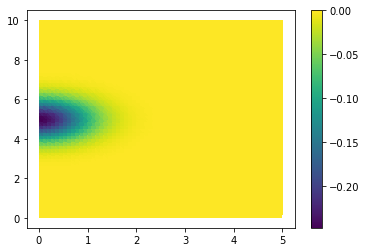

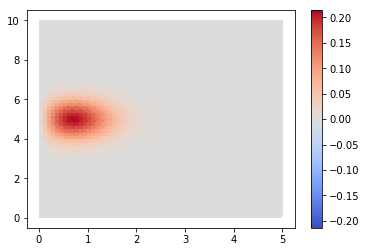

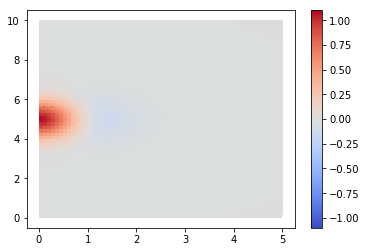

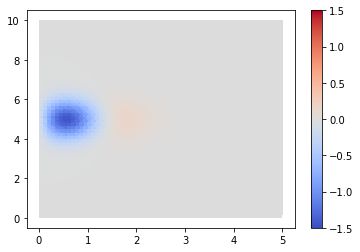

In [6]:
plot(Psib, cmap='viridis')

cv = Ub.vector().max()
plot(Ub, vmin=-cv, vmax=cv)

cv = Qb.vector().max()
plot(Qb, vmin=-cv, vmax=cv)

plot(dQb, vmin=-1.5, vmax=1.5)

In [7]:
# Define Petsc options
opts = PETSc.Options()
opts.setValue("eps_gen_non_hermitian", None)
opts.setValue("st_pc_factor_shift_type", "NONZERO")
opts.setValue("eps_type", "krylovschur")
opts.setValue("eps_largest_imaginary", None)
opts.setValue("eps_tol", 1e-10)

In [8]:
num_eigenvalues = 1

# Wavenumber
dk   = 1.
kk   = np.arange(1, 4, dk)
kL   = len(kk)

egs_re  = np.zeros((kL,num_eigenvalues))
egs_im  = np.zeros((kL,num_eigenvalues))

modes_re = [[]]*kL
modes_im = [[]]*kL

cnt = 0
for k in kk:

    k2   = Constant(k**2)

    ##
    ## Define Weak form
    ##
    
    # RHS
    a = (  ((x[0]*   phi*Ub).dx(0)) *  psi                \
         + ((x[0]**2*phi*Ub).dx(0)) * (psi.dx(0))         \
         + Ub * k2      *  phi        *  psi              \
         + x[0]**2 * ((Ub*phi).dx(1)) * (psi.dx(1)) / Bu2 \
         + x[0]**2 * phi * dQb * psi
        )*dx
    
    # LHS
    m = (  ((x[0]**2*phi).dx(0)) *  psi        \
         + ((x[0]**3*phi).dx(0)) * (psi.dx(0)) \
         +   x[0] * k2 * phi * psi    \
         +   x[0]**3 * (phi.dx(1)) * (psi.dx(1)) / Bu2 \
        )*dx

    petsc_a = assemble(a).M.handle
    petsc_m = assemble(m, bcs=bc).M.handle

    # Define Solver options
    es = SLEPc.EPS().create(comm=COMM_WORLD)
    es.setDimensions(num_eigenvalues)
    es.setOperators(petsc_a, petsc_m)
    es.setFromOptions()
    es.solve()

    nconv = es.getConverged()
    
    #if (nconv == 0):
    #    print("Failed to converge for k = {0:.3g}".format(k))
        
    imax = min(nconv, num_eigenvalues)
    
    for i in range(imax):
        vr, vi = petsc_a.getVecs()

        lam = es.getEigenpair(i, vr, vi)
        
        egs_re[cnt,i] = k*lam.real
        egs_im[cnt,i] = k*lam.imag
        
        # Store eigenvectors
        modes_re[cnt] = modes_re[cnt] + [Function(V)]
        modes_re[cnt][i].vector()[:] = vr
        
        modes_im[cnt] = modes_im[cnt] + [Function(V)]
        modes_im[cnt][i].vector()[:] = vi
        
    for i in range(imax,num_eigenvalues):
        egs_re[cnt,i] = np.nan
        egs_im[cnt,i] = np.nan
    
    cnt += 1
    
print('Done!')

Done!


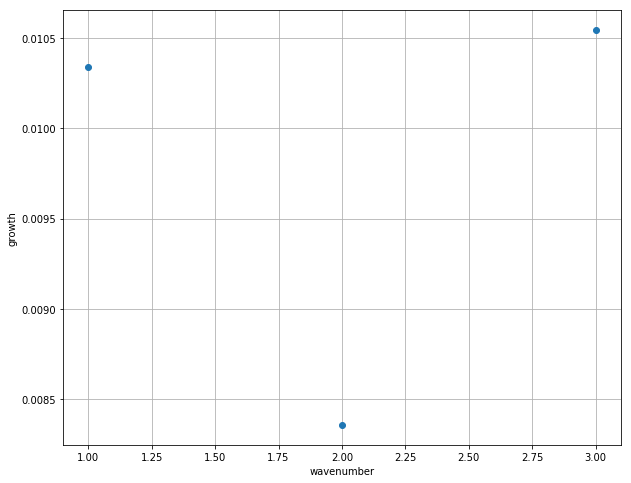

In [9]:
plt.figure(figsize=(10,8))
plt.plot(kk, egs_im[:,0], 'o')
plt.grid('on')
plt.xlabel('wavenumber')
plt.ylabel('growth')
plt.show()

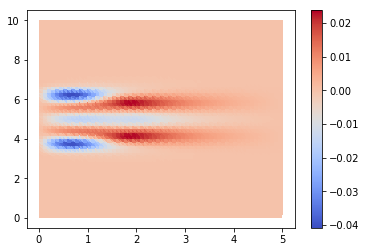

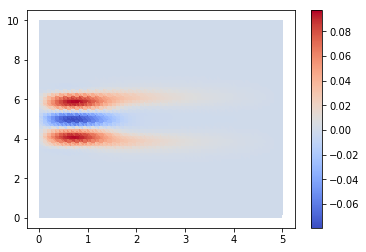

In [12]:
ki = 0
si = 0
plot(modes_re[ki][si])
plot(modes_im[ki][si])